<a href="https://colab.research.google.com/github/advapplab/sentiment_analysis_election_2022/blob/main/weibo_wmmBERT_testing_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

## 0-1 Install Dependences

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 0-2 Parameters

In [2]:
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [3]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1 Load Dataset

## 1-1 Download ICI election dataset

In [4]:
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx

File ‘df_sample.xlsx’ already there; not retrieving.



In [5]:
ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['angry']=0 #neg
    ici_map_dict['anger']=0 #neg
    ici_map_dict['positive']=1 #pos
    ici_map_dict['posiitive']=1 #pos
    ici_map_dict['happy']=1 #pos
    ici_map_dict['neutral']=3 #ignore
    ici_map_dict['neural']=3 #ignore
    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['suprise']=3 #ignore
    ici_map_dict['sad']=0 #neg
    ici_map_dict['negative']=0 #neg
    ici_map_dict['fear']=0 #neg

len(ici_map_dict)

12

In [6]:
import pandas as pd

In [7]:
testing_pd = pd.read_excel('/content/df_sample.xlsx')

testing_pd = testing_pd[['text', 'sentiment']]
testing_pd = testing_pd.rename(columns={'sentiment':'label'})

# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(200, 2)

In [8]:
testing_pd

,text,label
0,【谈北市选战三脚督柯文哲点出“2情况”：蓝绿都投黄珊珊】九合一选举年底登场，台北市长选战“三...,3
1,【黄珊珊民调反超陈时中、威胁蒋万安？ 郭正亮：关键在这群人】对于有台北市长选举民调显示，蒋万...,0
2,【台北市长选战若三脚督 阿扁最新预测：这人恐被弃保】台北市长选战，民进党参选人陈时中、国民党...,0
3,【这家民调蒋万安拉警报？ 郭正亮惊爆内幕：帮陈时中冲喜】对于《东森新闻》委托“雨晴民调公司”...,0
4,"【陈时中称蒋万安防疫主张抄袭自己 蒋万安：他防疫做得这么差 谁会想抄】<a href=""h...",1
...,...,...
195,中國國民黨台北市長參選人蔣萬安選情始終無法拉開，泛藍基本盤未歸隊是主因。前立法院長王金平上周...,3
196,【外传绿下周征召陈时中选台北市 蒋万安呛：任何个人决定都不该影响防疫】国民党台北市长参选人蒋...,3
197,【周玉蔻怎能霸占黄金时段？郭正亮爆：被“有分量”金主标下】资深媒体人周玉蔻日前攻击国民党台北...,3
198,额？？？这是蒋万安的竞选团队？？？,3


In [9]:
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
# title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"

testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [10]:
testing_pd

,text,label
0,对于有台北市长选举民调显示，蒋万安冲到39％，黄珊珊24％，陈时中18％。民众党台北市议员参...,0
1,台北市长选战，民进党参选人陈时中、国民党参选人蒋万安、民众党支持的台北市副市长黄珊珊等3人，...,0
2,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0
3,#台湾# 深圳卫视正午30分的微博视频,1
4,#叨哥有话说# 批台名嘴周玉蔻口无遮拦，马英九：蒋万安应该要告她,0
...,...,...
91,国民党台北市长参选人蒋万安新书今天上市。书中讲述他与老婆石舫亘爱情长跑20年的故事，蒋万安也...,0
92,资深媒体人周玉蔻近日言论火力全开，痛批慈济是中共自己人、甚至炮打证严法师，也扬言爆料国民党台...,0
93,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
94,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0


In [11]:
len(testing_pd.iloc[0]['text'])

113

In [12]:
if number_classes == 2:
    from sklearn.utils import resample

    df_majority = testing_pd[testing_pd.label==1]
    df_minority = testing_pd[testing_pd.label==0]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df_majority.shape[0],    # to match majority class
                                    random_state=42) # reproducible results

    # Combine majority class with upsampled minority class
    testing_pd = pd.concat([df_majority, df_minority_upsampled])


In [13]:
num_label = len(testing_pd['label'].unique())
num_label

2

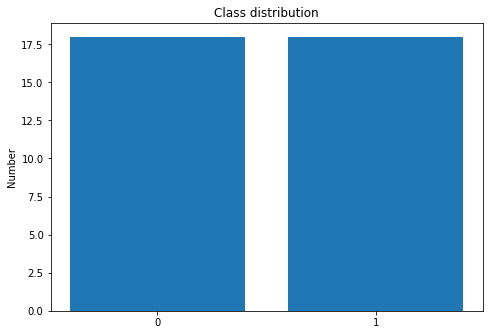

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(testing_pd['label'].unique(),
       testing_pd.groupby(['label']).count()['text'].tolist())

ax.set_xticks(testing_pd.groupby(['label']).count().index.values)

ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

## 1-2 Tokenization

In [15]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [16]:
from transformers import AutoTokenizer

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

In [18]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
full_test_dataset = tokenized_datasets["test"]

# 2. Testing

## 2-1 Download ICI model

In [20]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=num_label)

In [21]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


## 2-2 Get Accuracy

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
import numpy as np

# trainer.evaluate()

In [24]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 36
  Batch size = 8


In [25]:
pred.metrics

{'test_loss': 0.6014183163642883,
 'test_accuracy': 0.8611111111111112,
 'test_runtime': 78.74,
 'test_samples_per_second': 0.457,
 'test_steps_per_second': 0.064}

In [26]:
pred

PredictionOutput(predictions=array([[-1.7204889 ,  1.6388146 ],
       [-0.16413191,  0.49445623],
       [-2.2274156 ,  2.3561797 ],
       [-2.328325  ,  2.447178  ],
       [-2.627922  ,  2.648983  ],
       [-2.6224737 ,  2.6458027 ],
       [-1.8449811 ,  1.8254492 ],
       [-1.127352  ,  1.1875991 ],
       [-2.7164485 ,  2.70045   ],
       [ 1.5519042 , -1.9469279 ],
       [ 1.7712661 , -2.3355684 ],
       [-2.7057323 ,  2.69416   ],
       [-1.0034034 ,  1.1124574 ],
       [-2.2044578 ,  2.332473  ],
       [-2.6791973 ,  2.6787271 ],
       [-1.9006953 ,  1.9172282 ],
       [-1.6487442 ,  1.556221  ],
       [-1.6710702 ,  1.5803952 ],
       [ 1.6679479 , -2.1730351 ],
       [ 2.1429963 , -2.7647827 ],
       [ 2.4445143 , -3.591914  ],
       [ 2.1950727 , -2.834968  ],
       [ 1.7562492 , -2.3144    ],
       [ 1.7913073 , -2.3627837 ],
       [ 1.7913074 , -2.3627834 ],
       [ 2.3038683 , -3.1064787 ],
       [ 2.0315375 , -2.6380615 ],
       [ 2.3063278 , -3.11

In [27]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0])

In [28]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [29]:
testing_pd

,text,label,pred
3,#台湾# 深圳卫视正午30分的微博视频,1,1
8,九合一选举，台北市长选战成外界关注焦点！据最新民调显示，国民党参选人蒋万安以36.9%支持居...,1,1
13,国民党台北市长候选人蒋万安，1日出席同党南港内湖区议员候选人李明贤、士林北投区议员候选人陈重...,1,1
19,年底选举脚步逼近，新竹传出要蓝白合“用高虹安换蒋万安”。国民党台北市长参选人蒋万安表示，这个...,1,1
22,国民党台北市长参选人蒋万安选战布局挨批龟速、躺平，蒋上午受访回应，没有任何的躺平，而是奋战拼...,1,1
24,华夏经纬网8月1日讯：据台湾“联合新闻网”报道，台北市长参选人最新民调，国民党的蒋万安28%...,1,1
26,年底台北市长“三脚督”底定，有意参战的台北市副市长黄珊珊23日上午出席活动时，受到大同区至圣...,1,1
28,台北市环南市场昨举办普度活动，各党派台北市长参选人都相继参加，环南市场自治会长林胜东称黄珊珊...,1,1
32,国民党台北市长参选人蒋万安选情吃紧，2014年曾参选过台北市长的党副主席连胜文今天表示，蒋万...,1,1
33,爆周玉蔻与蒋万安决裂原因，徐巧芯：她以前动不动找蒋万安上节目 据台媒报道，台资深媒体人周玉...,1,0
